# Predicting energy consumption based on weather data

### Introduction

The objective of this project is to build a model which is capable of predicting the expected energy consumption level based on weather data. Therefore, a dataset which contains energy and weather data should be used, to detect and show possible correlations between weather data and energy demand. 

### The dataset
The dataset contains the following fields attributes:
- timestamp
- air_pressure[mmHg]
- air_temerature[degree celcius]
- relative_humudity[%]
- wind_speed[m/s]
- solar_irridiation[W/m^2]
- electricity_demand_values[kw]
- heat_demand_values[kw]

The dataset contains electrical and heat demand as well as weather data from December 2010 until November 2018 with an hourly resolution. It is critical to have fine-grained data points over a longer period of time to determine correlations between weather and energy demand. Furthermore, the energy demand data and weather data should not be spread across a wide geographical area, since discrepancies between the weather are more likely to occur and the quality of the data for training and evaluating the model is rapidly declining.

## Goals

For a better understanding of the dataset, an explorative data analysis will be done. The goal of this analysis is to detect which features correlate **strongly** with energy demand and which features *may* be less relevant.

In addition, a model will be trained and evaluated, to gain insights whether weather data is suitable for predicting the energy demand or not.

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import math
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')
np.random.seed(3)

In [2]:
df = pd.read_csv("./data/Load_data_new.csv")

# Set index to be of type DateTimeIndex for time-based interpolation to work
df["DATETIME_NUMERIC"] = df["Time"].apply(pd.to_datetime)
df.index = df["DATETIME_NUMERIC"]

# Explorative Data Analysis

In [3]:
df.describe()

,air_pressure[mmHg],air_temperature[degree celcius],relative_humidity[%],wind_speed[M/S],solar_irridiation[W/m²],electricity_demand_values[kw],heat_demand_values[kw],DATETIME_NUMERIC
count,69934.000000,69903.000000,69903.000000,69125.000000,70080.000000,70073.000000,70073.000000,70080
mean,734.588143,17.871834,60.644178,4.828268,257.293094,393.888975,263.506355,2014-11-29 23:30:00
min,716.500000,-14.400000,4.000000,0.000000,0.000000,112.947618,0.000000,2010-12-01 00:00:00
25%,731.400000,10.000000,43.000000,3.000000,0.000000,227.707914,0.000000,2012-11-29 23:45:00
50%,734.200000,18.900000,61.000000,5.000000,299.500000,323.093703,137.281603,2014-11-29 23:30:00
75%,737.500000,25.600000,79.000000,6.000000,499.000000,476.911512,448.289876,2016-11-28 23:15:00
max,757.500000,43.300000,100.000000,26.000000,699.000000,1592.893206,1529.168786,2018-11-28 23:00:00
std,5.011322,10.683280,22.007274,2.598960,258.725788,239.189061,314.704564,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70080 entries, 2010-12-01 00:00:00 to 2018-11-28 23:00:00
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Time                             70080 non-null  object        
 1   air_pressure[mmHg]               69934 non-null  float64       
 2   air_temperature[degree celcius]  69903 non-null  float64       
 3   relative_humidity[%]             69903 non-null  float64       
 4   wind_speed[M/S]                  69125 non-null  float64       
 5   solar_irridiation[W/m²]          70080 non-null  int64         
 6   total_cloud_cover[from ten]      69837 non-null  object        
 7   electricity_demand_values[kw]    70073 non-null  float64       
 8   heat_demand_values[kw]           70073 non-null  float64       
 9   DATETIME_NUMERIC                 70080 non-null  datetime64[ns]
dtypes: datetime64[ns](1), f

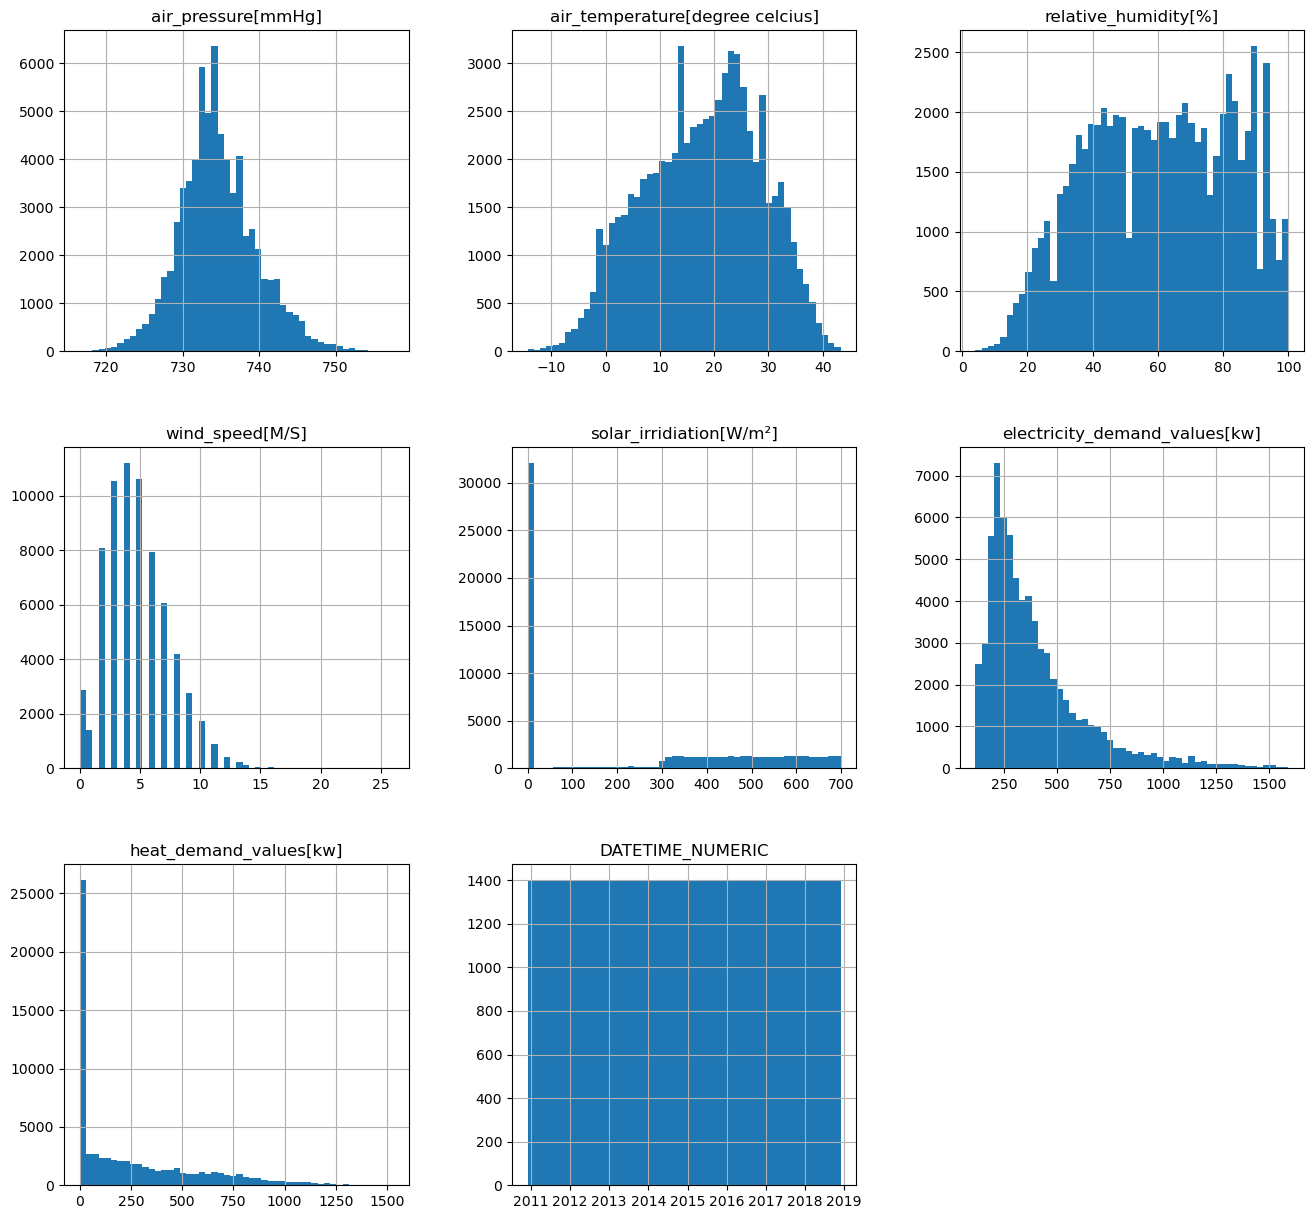

In [5]:
df.hist(bins=50, figsize=(16,15))
plt.show()

In [6]:
# Find NaN values in dataset to improve dataset quality.
df[df.isna().any(axis=1)]

,Time,air_pressure[mmHg],air_temperature[degree celcius],relative_humidity[%],wind_speed[M/S],solar_irridiation[W/m²],total_cloud_cover[from ten],electricity_demand_values[kw],heat_demand_values[kw],DATETIME_NUMERIC
DATETIME_NUMERIC,,,,,,,,,,
2010-12-06 10:00:00,2010-12-06 10:00:00,733.1,33.3,46.0,NaN,588,no clouds,333.817990,484.556708,2010-12-06 10:00:00
2010-12-16 15:00:00,2010-12-16 15:00:00,NaN,7.2,93.0,3.0,384,10/10.,375.382404,588.543953,2010-12-16 15:00:00
2010-12-16 16:00:00,2010-12-16 16:00:00,NaN,11.1,72.0,2.0,663,5/10.,451.820884,592.192796,2010-12-16 16:00:00
2010-12-26 13:00:00,2010-12-26 13:00:00,733.6,-2.2,96.0,7.0,600,NaN,381.252778,712.248685,2010-12-26 13:00:00
2011-01-22 01:00:00,2011-01-22 01:00:00,736.8,20.6,93.0,9.0,0,NaN,290.154445,610.812280,2011-01-22 01:00:00
...,...,...,...,...,...,...,...,...,...,...
2018-10-10 16:00:00,2018-10-10 16:00:00,728.6,19.0,94.0,4.0,460,NaN,244.096178,114.866493,2018-10-10 16:00:00
2018-10-16 20:00:00,2018-10-16 20:00:00,NaN,5.0,70.0,5.0,0,no clouds,228.941001,81.630709,2018-10-16 20:00:00
2018-10-16 22:00:00,2018-10-16 22:00:00,740.8,12.8,31.0,NaN,0,2/10–3/10.,258.874965,84.774228,2018-10-16 22:00:00


In [7]:
def plot_seasonal_decomposition(df, column_name, model='multiplicative'):
    result = seasonal_decompose(df[column_name], model=model)
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(df.index, df[column_name])
    plt.title("Original Time Series")

    plt.subplot(4, 1, 2)
    plt.plot(result.trend)
    plt.title("Trend Component")

    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal)
    plt.title("Seasonal Component")

    plt.subplot(4, 1, 4)
    plt.plot(result.resid)
    plt.title("Residual Component")

    plt.tight_layout()
    plt.show()

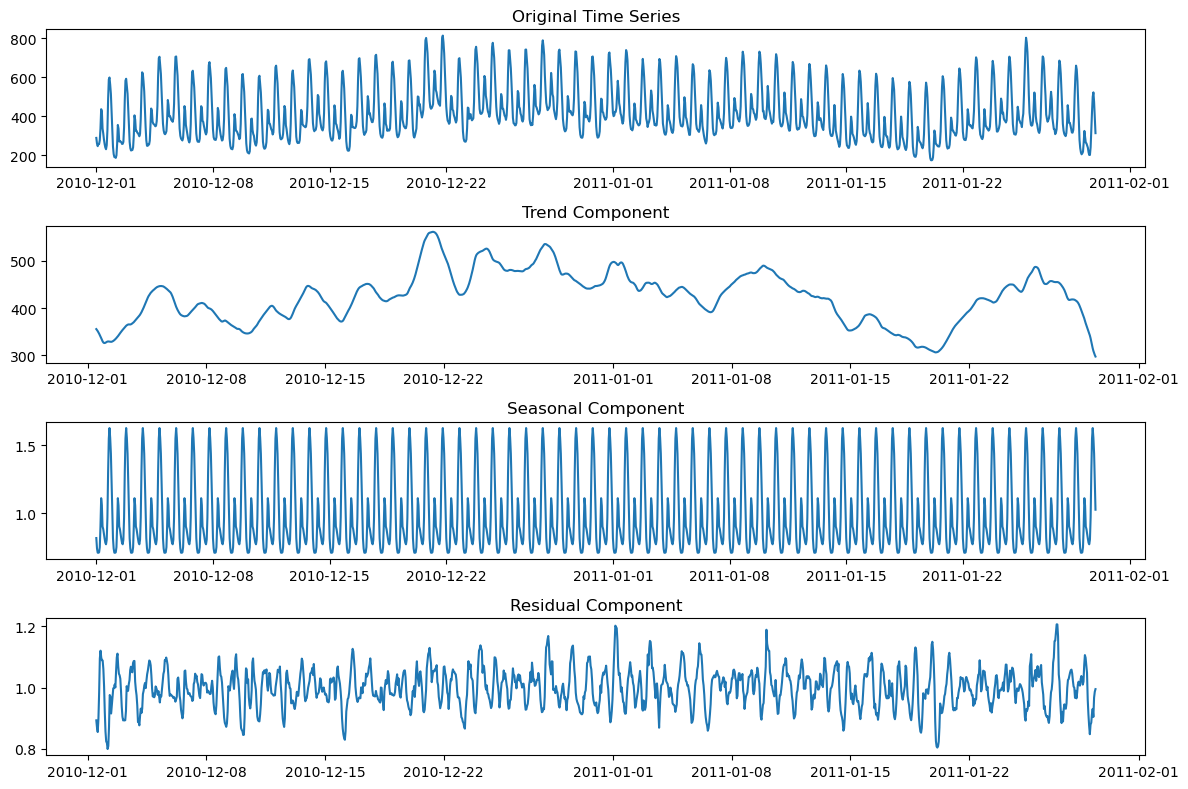

In [8]:
plot_seasonal_decomposition(df[:24*60], "electricity_demand_values[kw]")

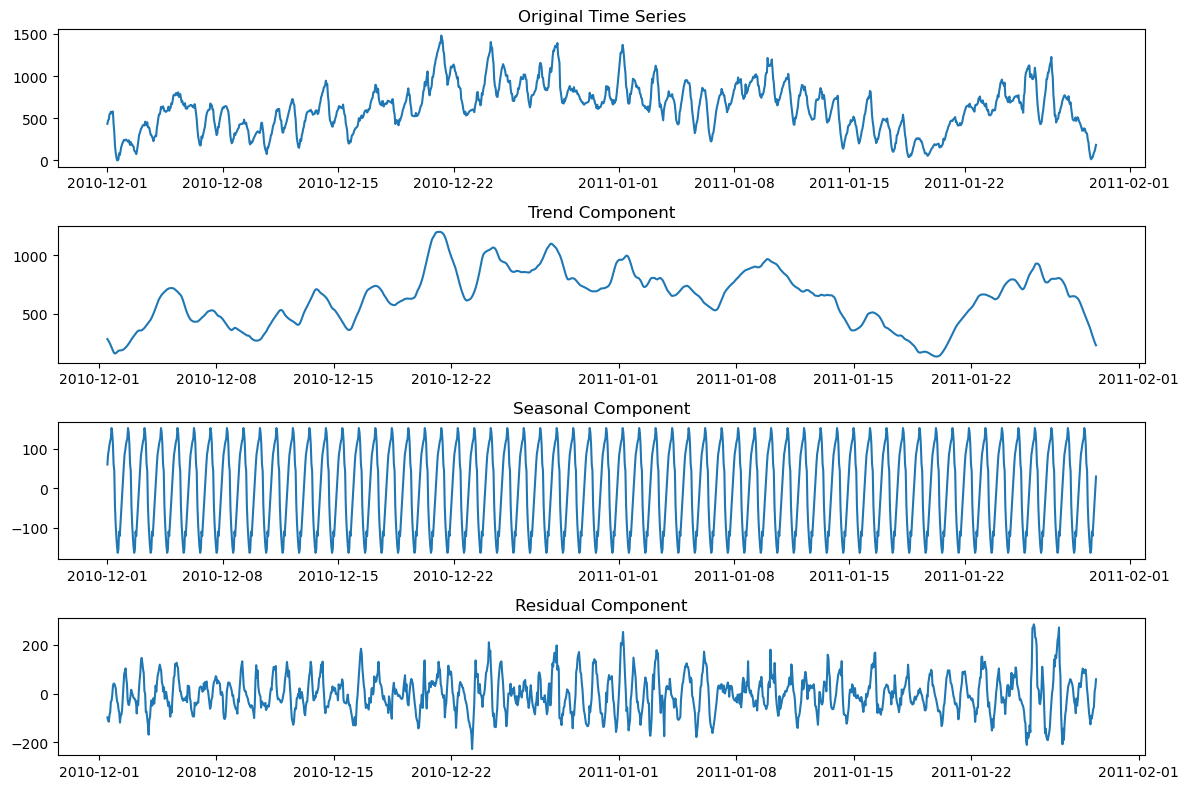

In [9]:
plot_seasonal_decomposition(df[:24*60], "heat_demand_values[kw]", model="additive")

## Data Cleaning

In [10]:
df.isna().sum()

Time                                 0
air_pressure[mmHg]                 146
air_temperature[degree celcius]    177
relative_humidity[%]               177
wind_speed[M/S]                    955
solar_irridiation[W/m²]              0
total_cloud_cover[from ten]        243
electricity_demand_values[kw]        7
heat_demand_values[kw]               7
DATETIME_NUMERIC                     0
dtype: int64

In [11]:
print ("\nMissing values :  ", df.isnull().any())


Missing values :   Time                               False
air_pressure[mmHg]                  True
air_temperature[degree celcius]     True
relative_humidity[%]                True
wind_speed[M/S]                     True
solar_irridiation[W/m²]            False
total_cloud_cover[from ten]         True
electricity_demand_values[kw]       True
heat_demand_values[kw]              True
DATETIME_NUMERIC                   False
dtype: bool


**Note**: 
- NaN values for air_pressure, air_temperatur, relative_humidity are values which can be derived from previous and following values since radical inclines/declines in those features are not likely. 
- NaN values for wind speed and total cloud cover will be replaced with 0. 
- Also: cloud cover will be transformed to numeric values for better results when training the model.

In [12]:
# Interpolation of derivable values
df["air_pressure[mmHg]"].interpolate(inplace=True, method="time", limit_direction="backward", limit=24)
df["air_temperature[degree celcius]"].interpolate(inplace=True, method="time", limit_direction="backward", limit=24)
df["relative_humidity[%]"].interpolate(inplace=True, method="time", limit_direction="backward", limit=24)
df["heat_demand_values[kw]"].interpolate(inplace=True, method="time", limit_direction="backward", limit=24) # DEBUG
df["electricity_demand_values[kw]"].interpolate(inplace=True, method="time", limit_direction="backward", limit=24) # DEBUG

In [13]:
# Combine similar windspeed categories into one class
df["wind_speed_cat[M/S]"] = np.ceil(df["wind_speed[M/S]"])
df["wind_speed_cat[M/S]"].where(df["wind_speed[M/S]"] < 10, 10, inplace=True)

In [14]:
# Replace NaN for cloud_cover with 0
# Reshape total_cloud_cover to float
cloud_mapping = {
    'no clouds': 0,
    'Sky obscured by fog and/or other meteorological phenomena.': 0,
    'nan': 0,
    '2/10–3/10.': 0.25,
    '5/10.': 0.5,
    '10/10.': 1.0,
    '7/10 – 8/10.': 0.75,
    '4/10.': 0.4   
}
df["total_cloud_cover_numeric[from ten]"] = df["total_cloud_cover[from ten]"].apply(lambda x: cloud_mapping.get(x))
df["total_cloud_cover_numeric[from ten]"].fillna(value=0, inplace=True)

**Note**: wind_speed[M/S] & total_cloud_cover[from ten] were cleaned by adding further derived features.

In [15]:
df["DATETIME_NUMERIC"] = df["Time"].apply(pd.to_datetime)

## Checking for missing values

In [16]:
df_cleaned = df.copy()

In [17]:
df_cleaned.drop(columns=["wind_speed[M/S]", "total_cloud_cover[from ten]", "Time"], inplace=True)

In [18]:
# electricity_demand/heat_demand are not iterpolated.
df_cleaned.isnull().sum()

air_pressure[mmHg]                     0
air_temperature[degree celcius]        0
relative_humidity[%]                   0
solar_irridiation[W/m²]                0
electricity_demand_values[kw]          0
heat_demand_values[kw]                 0
DATETIME_NUMERIC                       0
wind_speed_cat[M/S]                    0
total_cloud_cover_numeric[from ten]    0
dtype: int64

In [19]:
print ("\nMissing values :  ")
print(df_cleaned.isnull().any())


Missing values :  
air_pressure[mmHg]                     False
air_temperature[degree celcius]        False
relative_humidity[%]                   False
solar_irridiation[W/m²]                False
electricity_demand_values[kw]          False
heat_demand_values[kw]                 False
DATETIME_NUMERIC                       False
wind_speed_cat[M/S]                    False
total_cloud_cover_numeric[from ten]    False
dtype: bool


## Statistical Analysis

In [20]:
df_copy = df_cleaned.copy()
df_copy.set_index(keys="DATETIME_NUMERIC", inplace=True)
df_copy.index

DatetimeIndex(['2010-12-01 00:00:00', '2010-12-01 01:00:00',
               '2010-12-01 02:00:00', '2010-12-01 03:00:00',
               '2010-12-01 04:00:00', '2010-12-01 05:00:00',
               '2010-12-01 06:00:00', '2010-12-01 07:00:00',
               '2010-12-01 08:00:00', '2010-12-01 09:00:00',
               ...
               '2018-11-28 14:00:00', '2018-11-28 15:00:00',
               '2018-11-28 16:00:00', '2018-11-28 17:00:00',
               '2018-11-28 18:00:00', '2018-11-28 19:00:00',
               '2018-11-28 20:00:00', '2018-11-28 21:00:00',
               '2018-11-28 22:00:00', '2018-11-28 23:00:00'],
              dtype='datetime64[ns]', name='DATETIME_NUMERIC', length=70080, freq=None)

**Note**: For further statistical analysis of the timeseries, a DateTimeIndex is recommended.

### Augmented Dickey-Fuller 
The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation. It is used to assess whether the timeseries data is stationary or not.

- H0: The data is **not** stationary.
- H1: The data is stationary (or trend-stationary).

In [21]:
def augmented_dickey_fuller_matrix(df: pd.DataFrame, columns: pd.DataFrame.columns, autolag="AIC"):
    result_cols = ["Name", "adfstat", "pvalue", "usedlag"]
    df_result = None
    for idx, col in enumerate(columns):
        print(f'Performing Augmented Dickey Fuller for {col}')
        adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(df[col], autolag=autolag)
        dct = dict(zip([*result_cols, *[f'crit_val_{x}' for x in critvalues.keys()]], [col, adfstat, pvalue, usedlag, *critvalues.values()]))
        if idx == 0:
            df_result = pd.DataFrame(dct, index=[idx])
            continue
        df_result = pd.concat([df_result,pd.DataFrame(dct, index=[idx])], ignore_index=True)
        
    return df_result
        

In [22]:
augmented_dickey_fuller_matrix(df_copy, columns=df_copy.columns)

Performing Augmented Dickey Fuller for air_pressure[mmHg]
Performing Augmented Dickey Fuller for air_temperature[degree celcius]
Performing Augmented Dickey Fuller for relative_humidity[%]
Performing Augmented Dickey Fuller for solar_irridiation[W/m²]
Performing Augmented Dickey Fuller for electricity_demand_values[kw]
Performing Augmented Dickey Fuller for heat_demand_values[kw]
Performing Augmented Dickey Fuller for wind_speed_cat[M/S]
Performing Augmented Dickey Fuller for total_cloud_cover_numeric[from ten]


,Name,adfstat,pvalue,usedlag,crit_val_1%,crit_val_5%,crit_val_10%
0,air_pressure[mmHg],-21.335919,0.000000e+00,62,-3.430443,-2.861581,-2.566792
1,air_temperature[degree celcius],-8.108459,1.244356e-12,61,-3.430443,-2.861581,-2.566792
2,relative_humidity[%],-21.853121,0.000000e+00,56,-3.430443,-2.861581,-2.566792
3,solar_irridiation[W/m²],-36.504272,0.000000e+00,62,-3.430443,-2.861581,-2.566792
4,electricity_demand_values[kw],-18.080651,2.587575e-30,62,-3.430443,-2.861581,-2.566792
5,heat_demand_values[kw],-7.792917,7.854580e-12,62,-3.430443,-2.861581,-2.566792
6,wind_speed_cat[M/S],-24.053629,0.000000e+00,59,-3.430443,-2.861581,-2.566792
7,total_cloud_cover_numeric[from ten],-29.109673,0.000000e+00,62,-3.430443,-2.861581,-2.566792


### Interpretation of the result

Since the p-values for all features are **less** than the significance level (0.05) and **all** critical values are **greater** than the `ADF Statistic`, the null hypothesis can be rejected. This implies that all features/timeseries are stationary, which is a key requirement for performing Multivariate Timeseries Forecasting.



## Granger Causality Test

**Note**: Implementation details can be found here: https://www.machinelearningplus.com/time-series/granger-causality-test-in-python/

In [23]:
maxlag = 30 # 30 Days

test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=verbose)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [24]:
df_copy.dropna(inplace=True)
grangers_caustaiton_matrix_result = grangers_causation_matrix(df_copy, variables=df_copy.columns)

In [25]:
grangers_caustaiton_matrix_result

,air_pressure[mmHg]_x,air_temperature[degree celcius]_x,relative_humidity[%]_x,solar_irridiation[W/m²]_x,electricity_demand_values[kw]_x,heat_demand_values[kw]_x,wind_speed_cat[M/S]_x,total_cloud_cover_numeric[from ten]_x
air_pressure[mmHg]_y,1.0000,0.0000,0.0000,0.6661,0.0193,0.0165,0.0000,0.0000
air_temperature[degree celcius]_y,0.0000,1.0000,0.0000,0.6282,0.0030,0.0663,0.0000,0.0000
relative_humidity[%]_y,0.0000,0.0000,1.0000,0.2864,0.0000,0.1706,0.0000,0.0000
solar_irridiation[W/m²]_y,0.0787,0.1372,0.0480,1.0000,0.0000,0.0000,0.2406,0.1249
electricity_demand_values[kw]_y,0.0914,0.0014,0.0001,0.0000,1.0000,0.0000,0.0001,0.0133
heat_demand_values[kw]_y,0.0040,0.0034,0.0061,0.0000,0.0000,1.0000,0.1958,0.0076
wind_speed_cat[M/S]_y,0.0000,0.0000,0.0000,0.4266,0.0012,0.0823,1.0000,0.0000
total_cloud_cover_numeric[from ten]_y,0.0000,0.0000,0.0000,0.5552,0.3848,0.0977,0.0000,1.0000


In [26]:
grangers_caustaiton_matrix_result.loc[["electricity_demand_values[kw]_y", "heat_demand_values[kw]_y"]]

,air_pressure[mmHg]_x,air_temperature[degree celcius]_x,relative_humidity[%]_x,solar_irridiation[W/m²]_x,electricity_demand_values[kw]_x,heat_demand_values[kw]_x,wind_speed_cat[M/S]_x,total_cloud_cover_numeric[from ten]_x
electricity_demand_values[kw]_y,0.0914,0.0014,0.0001,0.0,1.0,0.0,0.0001,0.0133
heat_demand_values[kw]_y,0.0040,0.0034,0.0061,0.0,0.0,1.0,0.1958,0.0076


### Interpretation of the result

Let's take the value 0.0040 (row 2, column 1) it refers to the p-value of `air_pressure[mmHg]_x` causing `heat_demand_values[kw]_y`. How do we interpret the p-values?

If a given p-value is less than the significance level (0.05), then, the corresponding X series (column) causes the Y (row). With other words, if p < alpha (significance level) the null hypothesis can be rejected and the conclusion that X causes Y can be done. 

How can we use this result?

H0: X does not granger cause Y\
H1: X does granger cause Y, **if p-value > 0.05 then H0 is accepted**, i.e. X does not granger cause Y.

What does this mean for the dataset?
If we take a look at the `electricity_demand_values[kw]_y` and `heat_demand_values[kw]_y` we can see that some of the p-values for most `Xs` are **> 0.05**. This means that the null hypothesis *X does not cause Y* can be rejected. For the further predictions, we should split the dataset into two. One for predicting `electricity_demand_values[kw]` and one for predicting `heat_demand_values[kw]`. 

In [27]:
df_heat_raw = df_cleaned.copy()
df_elec_raw = df_cleaned.copy()

In [28]:
# Drop columns in both dataframes where H0 is accepted.
df_heat = df_heat_raw.drop(columns=["electricity_demand_values[kw]","wind_speed_cat[M/S]"])
df_elec = df_elec_raw.drop(columns=[ "heat_demand_values[kw]", "air_pressure[mmHg]"])
# df_heat = df_heat_raw.drop(columns=["electricity_demand_values[kw]"])
# df_elec = df_elec_raw.drop(columns=["heat_demand_values[kw]"])

In [29]:
df_heat.info()
df_elec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70080 entries, 2010-12-01 00:00:00 to 2018-11-28 23:00:00
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   air_pressure[mmHg]                   70080 non-null  float64       
 1   air_temperature[degree celcius]      70080 non-null  float64       
 2   relative_humidity[%]                 70080 non-null  float64       
 3   solar_irridiation[W/m²]              70080 non-null  int64         
 4   heat_demand_values[kw]               70080 non-null  float64       
 5   DATETIME_NUMERIC                     70080 non-null  datetime64[ns]
 6   total_cloud_cover_numeric[from ten]  70080 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 4.3 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70080 entries, 2010-12-01 00:00:00 to 2018-11-28 23:00:00
Data columns (total 

In [30]:
# change DATETIME_NUMERIC to be index
df_heat.set_index(keys="DATETIME_NUMERIC", inplace=True)
df_elec.set_index(keys="DATETIME_NUMERIC", inplace=True)

### Split the data into training and tesing data

**Note**: The data will be split into 3 sets:

- [X] Training Data (70%)
- [X] Validation Data (20%)
- [X] Test Data (10%)

In [31]:
def test_train_validate_split(df: pd.DataFrame, percentages=(0.70,0.10,0.20)):
    return np.split(df, [int(percentages[0] * len(df)), int((percentages[0] + percentages[1]) * len(df))])

In [32]:
df_heat_train, df_heat_validate, df_heat_test = test_train_validate_split(df_heat)
df_elec_train, df_elec_validate, df_elec_test = test_train_validate_split(df_elec)

print(f"df_heat_train.shape: {df_heat_train.shape}")
print(f"df_heat_validate.shape: {df_heat_validate.shape}")
print(f"df_heat_test.shape: {df_heat_test.shape}")

print(f"df_elec_train.shape: {df_elec_train.shape}")
print(f"df_elec_validate.shape: {df_elec_validate.shape}")
print(f"df_elec_test.shape: {df_elec_test.shape}")


df_heat_train.shape: (49056, 6)
df_heat_validate.shape: (7007, 6)
df_heat_test.shape: (14017, 6)
df_elec_train.shape: (49056, 6)
df_elec_validate.shape: (7007, 6)
df_elec_test.shape: (14017, 6)


In [33]:
with open("./data/heat_data.pkl", "wb") as f:
    df_heat_combined = {
        "df_heat_train": df_heat_train,
        "df_heat_test": df_heat_test,
        "df_heat_validate": df_heat_validate
    }
    pickle.dump(df_heat_combined, f)

with open("./data/elec_data.pkl", "wb") as f:
    df_elec_combined = {
        "df_elec_train": df_elec_train,
        "df_elec_test": df_elec_test,
        "df_elec_validate": df_elec_validate
    }
    pickle.dump(df_elec_combined, f)


### Sanity Checks

In [34]:
with open("./data/heat_data.pkl", "rb") as f:
    loaded_heat_data = pickle.load(f)
    
with open("./data/elec_data.pkl", "rb") as f:
    loaded_elec_data = pickle.load(f)

In [35]:
assert loaded_heat_data["df_heat_train"].equals(df_heat_train)
assert loaded_heat_data["df_heat_test"].equals(df_heat_test)
assert loaded_heat_data["df_heat_validate"].equals(df_heat_validate)

assert loaded_elec_data["df_elec_train"].equals(df_elec_train)
assert loaded_elec_data["df_elec_test"].equals(df_elec_test)
assert loaded_elec_data["df_elec_validate"].equals(df_elec_validate)

In [36]:
loaded_elec_data["df_elec_validate"].shape

(7007, 6)

# Model Implementation

In the following section, three models are implemented:

1. The *naive* approach (using plain `sklearn` `RandomForestRegressor`)
2. Univariate Forecasting (using `skforecast` `ForecasterAutoreg`)
3. Multivariate Forecasting (using `skforecast` `ForecasterAutoregMultiVariate`)



In [37]:
with open("./data/elec_data.pkl", "rb") as f:
    loaded_elec_data = pickle.load(f)

In [38]:
def test_train_validate_split(df: pd.DataFrame, percentages=(0.70,0.10,0.20)):
    return np.split(df, [int(percentages[0] * len(df)), int((percentages[0] + percentages[1]) * len(df))])

In [39]:
df_elec_data = pd.concat([loaded_elec_data["df_elec_train"], loaded_elec_data["df_elec_validate"], loaded_elec_data["df_elec_test"]])
df_elec_data = df_elec_data.resample("D").mean()

df_elec_train, df_elec_validate, df_elec_test = test_train_validate_split(df_elec_data)
df_elec_test.shape

(584, 6)

In [40]:
assert loaded_heat_data["df_heat_train"].shape == (49056, 6)
assert loaded_heat_data["df_heat_test"].shape == (14017, 6)
assert loaded_heat_data["df_heat_validate"].shape == (7007, 6)

assert loaded_elec_data["df_elec_train"].shape == (49056, 6)
assert loaded_elec_data["df_elec_test"].shape == (14017, 6)
assert loaded_elec_data["df_elec_validate"].shape == (7007, 6)


In [41]:
def display_time_series(df_train, df_validate, df_test, col="", figsize=(15,5), title="", ):
    ax = df_train[col].plot(figsize=figsize, color="tab:blue", label="Train")
    _ = df_test[col].plot(ax=ax, color="tab:red", label="Test")
    _ = df_validate[col].plot(ax=ax, color="tab:orange", label="Validate")
    
    ax.legend()
    ax.axvline(df_validate.index[0], linestyle=":")
    ax.axvline(df_test.index[0], linestyle=":")
    
    plt.title(title)
    plt.show()

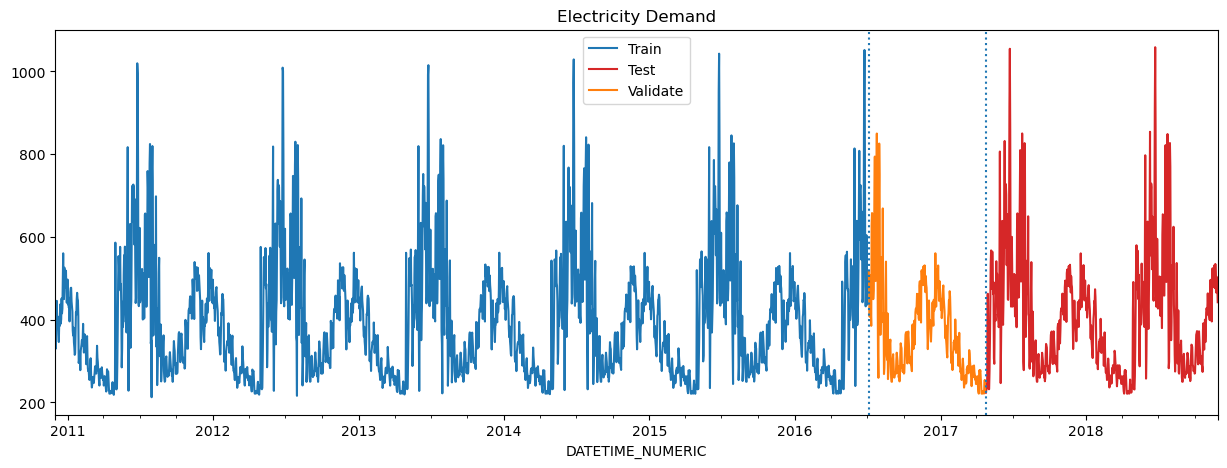

In [42]:
# display_time_series(df_heat_train, df_heat_validate, df_heat_test, col="heat_demand_values[kw]", title="Heat Demand")
display_time_series(df_elec_train, df_elec_validate, df_elec_test, col="electricity_demand_values[kw]", title="Electricity Demand")

In [43]:
print(f"Train Period: {df_elec_train.index.min()}      ===> {df_elec_train.index.max()} shape: {df_elec_train.shape}")
print(f"Validation Period: {df_elec_validate.index.min()} ===> {df_elec_validate.index.max()} shape: {df_elec_validate.shape}")
print(f"Test Period: {df_elec_test.index.min()}       ===> {df_elec_test.index.max()} shape: {df_elec_test.shape}")


Train Period: 2010-12-01 00:00:00      ===> 2016-07-04 00:00:00 shape: (2043, 6)
Validation Period: 2016-07-05 00:00:00 ===> 2017-04-23 00:00:00 shape: (293, 6)
Test Period: 2017-04-24 00:00:00       ===> 2018-11-28 00:00:00 shape: (584, 6)


## The *naive* approach

In [44]:
X_train = df_elec_train.drop(columns="electricity_demand_values[kw]")
y_train = df_elec_train["electricity_demand_values[kw]"]

X_test = df_elec_test.drop(columns="electricity_demand_values[kw]")
y_test = df_elec_test["electricity_demand_values[kw]"]


In [45]:
X_train

,air_temperature[degree celcius],relative_humidity[%],solar_irridiation[W/m²],wind_speed_cat[M/S],total_cloud_cover_numeric[from ten]
DATETIME_NUMERIC,,,,,
2010-12-01,27.779167,76.666667,266.833333,3.833333,0.218750
2010-12-02,28.504167,71.750000,271.916667,6.541667,0.145833
2010-12-03,25.712500,71.500000,239.291667,4.708333,0.187500
2010-12-04,26.991667,58.250000,271.791667,6.375000,0.291667
2010-12-05,25.004167,44.416667,260.750000,5.500000,0.062500
...,...,...,...,...,...
2016-06-30,25.700000,69.000000,267.666667,6.125000,0.354167
2016-07-01,27.191667,61.833333,259.791667,6.125000,0.208333
2016-07-02,22.820833,51.875000,271.625000,2.875000,0.020833


In [46]:
model = RandomForestRegressor(max_depth=10)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [47]:
y_pred = model.predict(X_test)

In [48]:
mape = mean_absolute_percentage_error(y_test, y_pred)

In [49]:
y_pred_mapped = pd.Series(y_pred, index=y_test.index)

In [50]:
y_pred_mapped

DATETIME_NUMERIC
2017-04-24    379.273244
2017-04-25    367.146874
2017-04-26    421.151509
2017-04-27    382.522345
2017-04-28    401.039327
                 ...    
2018-11-24    374.720469
2018-11-25    340.508183
2018-11-26    416.667939
2018-11-27    375.446038
2018-11-28    378.442085
Freq: D, Length: 584, dtype: float64

In [51]:
print(f"MAPE: {mape}")

MAPE: 0.2786607528825778


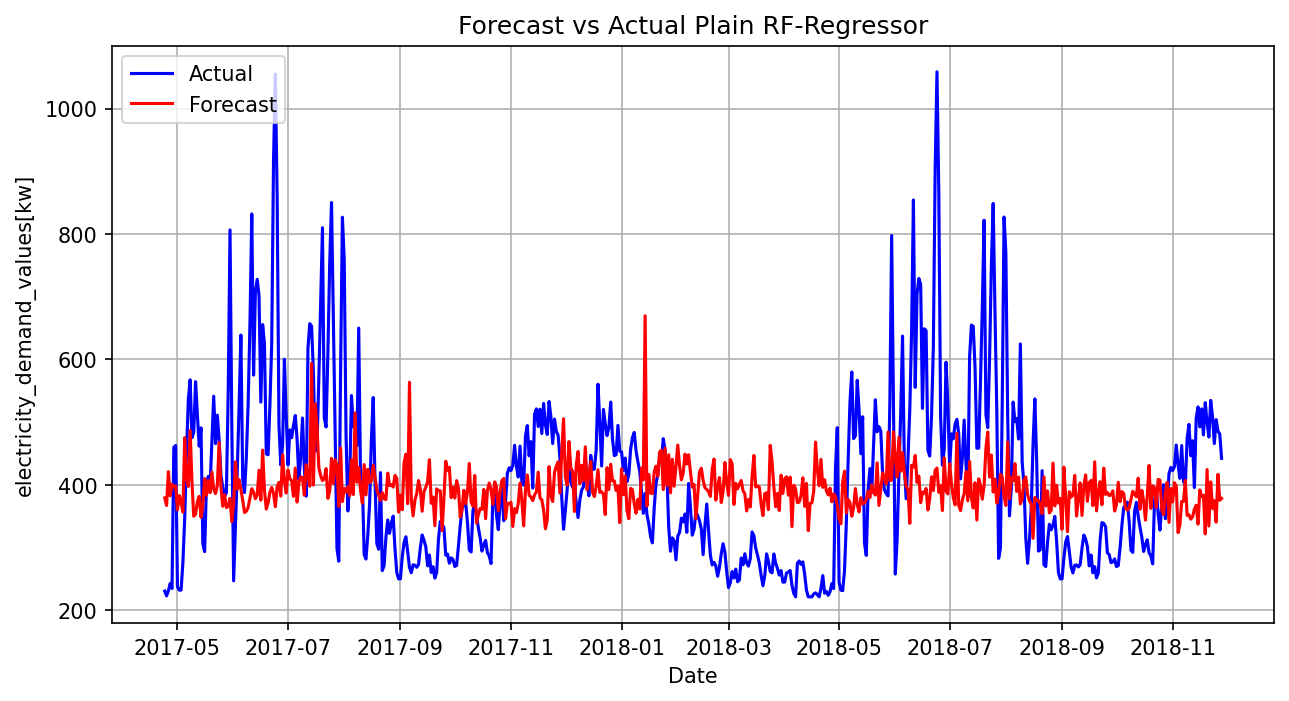

In [52]:
def plot_forecast_vs_actual(actual:pd.Series, forecast: pd.Series, title, ylabel="electricity_demand_values[kw]", figsize=(10,5),) -> None:
    fig = plt.figure(dpi=150, figsize=figsize)
    plt.plot(actual.index, actual, label='Actual',  color='b')
    plt.plot(forecast.index, forecast, label='Forecast', color='r')
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.title(f'Forecast vs Actual {title}')
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

plot_forecast_vs_actual(df_elec_test["electricity_demand_values[kw]"],y_pred_mapped, title="Plain RF-Regressor")

## Modelling a univariate Timeseries

In [53]:
df_elec_data.head()

,air_temperature[degree celcius],relative_humidity[%],solar_irridiation[W/m²],electricity_demand_values[kw],wind_speed_cat[M/S],total_cloud_cover_numeric[from ten]
DATETIME_NUMERIC,,,,,,
2010-12-01,27.779167,76.666667,266.833333,356.243842,3.833333,0.218750
2010-12-02,28.504167,71.750000,271.916667,329.619600,6.541667,0.145833
2010-12-03,25.712500,71.500000,239.291667,364.953960,4.708333,0.187500
2010-12-04,26.991667,58.250000,271.791667,417.211125,6.375000,0.291667
2010-12-05,25.004167,44.416667,260.750000,445.594869,5.500000,0.062500


In [54]:
items = list(df_elec_data.columns)


forecaster_ms = ForecasterAutoreg(
    regressor         = RandomForestRegressor(random_state=42, max_depth=10),
    lags              = 30,
)

single_series_mae, predictions_ss = backtesting_forecaster(
                                       forecaster         = forecaster_ms,
                                       y                  = df_elec_data["electricity_demand_values[kw]"],
                                       steps              = 7,
                                       metric             = 'mean_absolute_percentage_error',
                                       initial_train_size = len(df_elec_train),
                                       refit              = False,
                                       fixed_train_size   = True,
                                       verbose            = False,
                                       show_progress      = True )

  0%|          | 0/126 [00:00<?, ?it/s]

In [55]:
print("Backtest metrics")
display(single_series_mae)
print("")
print("Backtest predictions")
predictions_ss.head(4)

Backtest metrics


0.09658264648205112


Backtest predictions


,pred
2016-07-05,501.928700
2016-07-06,455.966501
2016-07-07,412.093403
2016-07-08,423.003613


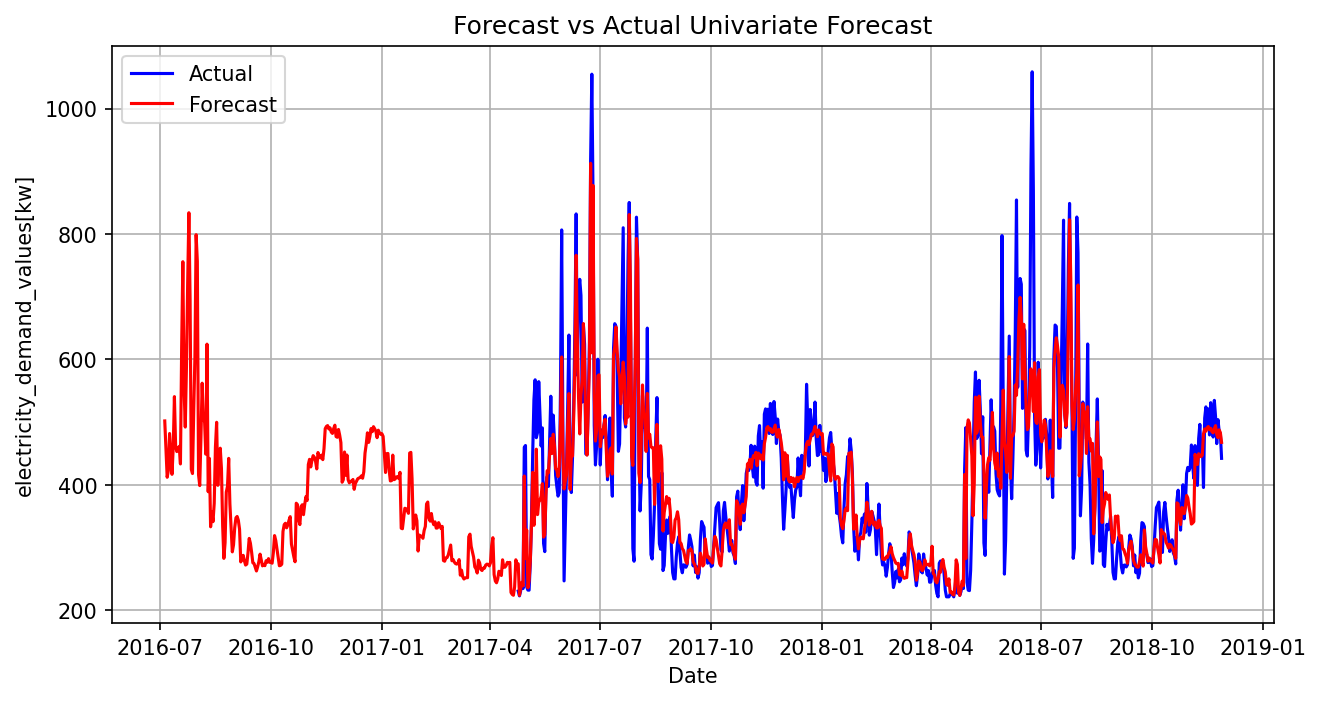

In [56]:
plot_forecast_vs_actual(df_elec_test["electricity_demand_values[kw]"], predictions_ss, title="Univariate Forecast")

## Modelling a multivariate Timeseries

In [57]:
df_elec_data.head()

,air_temperature[degree celcius],relative_humidity[%],solar_irridiation[W/m²],electricity_demand_values[kw],wind_speed_cat[M/S],total_cloud_cover_numeric[from ten]
DATETIME_NUMERIC,,,,,,
2010-12-01,27.779167,76.666667,266.833333,356.243842,3.833333,0.218750
2010-12-02,28.504167,71.750000,271.916667,329.619600,6.541667,0.145833
2010-12-03,25.712500,71.500000,239.291667,364.953960,4.708333,0.187500
2010-12-04,26.991667,58.250000,271.791667,417.211125,6.375000,0.291667
2010-12-05,25.004167,44.416667,260.750000,445.594869,5.500000,0.062500


In [58]:
items = list(df_elec_data.columns)


forecaster_ms = ForecasterAutoregMultiVariate(
    regressor         = RandomForestRegressor(random_state=42, max_depth=10),
    lags              = 30,
    level             = "electricity_demand_values[kw]",
    steps             = 10
)

multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = df_elec_data,
                                       steps              = 7,
                                       metric             = 'mean_absolute_percentage_error',
                                       initial_train_size = len(df_elec_train),
                                       refit              = False,
                                       fixed_train_size   = True,
                                       verbose            = False,
                                       show_progress      = True )

  0%|          | 0/126 [00:00<?, ?it/s]

In [59]:
print("Backtest metrics")
display(multi_series_mae)
print("")
print("Backtest predictions")
predictions_ms.head(4)

Backtest metrics


,levels,mean_absolute_percentage_error
0,electricity_demand_values[kw],0.066399



Backtest predictions


,electricity_demand_values[kw]
2016-07-05,499.793380
2016-07-06,530.154931
2016-07-07,440.872926
2016-07-08,427.545669


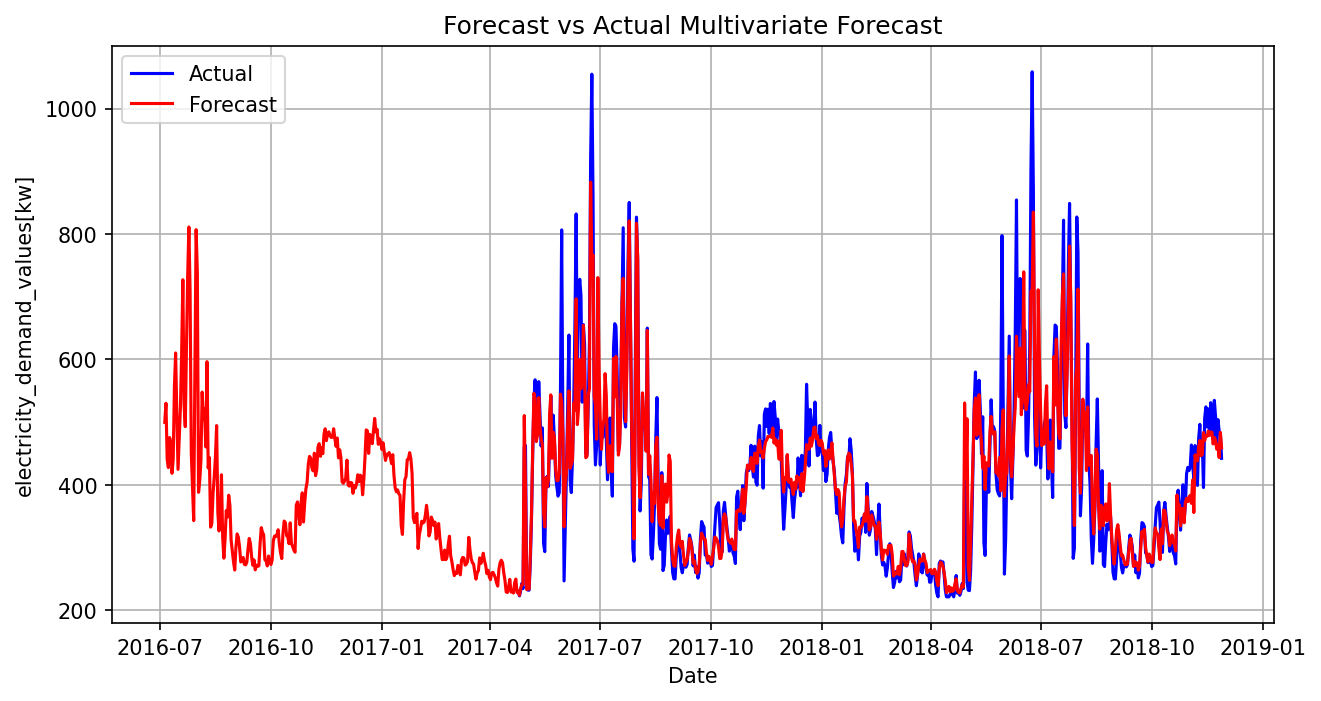

In [60]:
plot_forecast_vs_actual(df_elec_test["electricity_demand_values[kw]"], predictions_ms, title="Multivariate Forecast")